In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Smart Irrigation System using NASA POWER Data

## Introduction
This project uses NASA POWER satellite data to predict water requirements for different crops. The goal is to help farmers determine optimal irrigation amounts based on weather conditions.

### About the Dataset
NASA POWER provides free satellite weather data that can be accessed from anywhere in the world. The dataset includes:

**Main Features:**
- **ALLSKY_SFC_SW_DWN**: Solar radiation (kW-hr/m²/day)
- **RH2M**: Relative Humidity at 2 meters (%)
- **WS2M**: Wind Speed at 2 meters (m/s)
- **T2M_MAX**: Maximum Temperature (°C)
- **T2M_MIN**: Minimum Temperature (°C)

**Dataset Details:**
- Source: NASA POWER (power.larc.nasa.gov)
- Time Period: 2015-2025
- Total Records: 3,656 daily observations
- Location: Punjab region data

### Objective
Build a machine learning model to predict crop water requirements based on weather parameters

## Import Required Libraries

In [3]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Statistical analysis
from scipy import stats
from scipy.stats import pearsonr, spearmanr

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

pd.set_option('display.max_columns', None)

print("Libraries imported successfully")

Libraries imported successfully


## Load Dataset

In [4]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/nasa_power_dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"Date range: {df['YEAR'].min()} to {df['YEAR'].max()}")
print("\nFirst few rows:")
df.head(10)

Dataset shape: (3654, 7)
Columns: ['YEAR', 'DOY', 'ALLSKY_SFC_SW_DWN', 'RH2M', 'WS2M', 'T2M_MAX', 'T2M_MIN']
Date range: 2015 to 2025

First few rows:


,YEAR,DOY,ALLSKY_SFC_SW_DWN,RH2M,WS2M,T2M_MAX,T2M_MIN
0,2015,303,10.81,86.15,5.27,18.83,18.01
1,2015,304,13.37,84.57,3.54,18.96,17.98
2,2015,305,15.89,85.68,5.15,19.55,18.11
3,2015,306,14.07,70.51,10.25,18.32,17.31
4,2015,307,12.44,70.97,9.31,18.47,17.81
5,2015,308,12.44,78.07,6.95,18.24,17.51
6,2015,309,13.26,72.91,3.57,18.18,17.44
7,2015,310,9.28,68.94,3.29,18.27,17.56
8,2015,311,12.57,82.43,4.94,18.90,17.49
9,2015,312,10.56,72.61,7.52,18.09,16.81


In [5]:
# Check data info
print("Dataset Info:")
df.info()

print("\nStatistical Summary:")
df.describe().round(2)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3654 entries, 0 to 3653
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   YEAR               3654 non-null   int64  
 1   DOY                3654 non-null   int64  
 2   ALLSKY_SFC_SW_DWN  3654 non-null   float64
 3   RH2M               3654 non-null   float64
 4   WS2M               3654 non-null   float64
 5   T2M_MAX            3654 non-null   float64
 6   T2M_MIN            3654 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 200.0 KB

Statistical Summary:


,YEAR,DOY,ALLSKY_SFC_SW_DWN,RH2M,WS2M,T2M_MAX,T2M_MIN
count,3654.00,3654.00,3654.00,3654.00,3654.00,3654.00,3654.00
mean,2020.33,183.18,14.36,82.29,5.23,15.67,14.70
std,2.90,105.47,41.60,31.80,28.87,29.18,29.16
min,2015.00,1.00,-999.00,-999.00,-999.00,-999.00,-999.00
25%,2018.00,92.00,10.84,78.00,4.52,14.74,13.59
50%,2020.00,183.00,15.60,83.18,6.04,16.39,15.39
75%,2023.00,274.75,20.87,88.36,7.52,18.25,17.46
max,2025.00,366.00,31.90,98.29,13.36,22.73,21.73


## Data Cleaning

NASA POWER uses -999 to indicate missing data

In [6]:
# Check for missing values (coded as -999)
print("Checking for missing values (-999):")

for col in df.columns:
    if col not in ['YEAR', 'DOY']:
        missing_count = (df[col] == -999).sum()
        if missing_count > 0:
            print(f"{col}: {missing_count} missing ({missing_count/len(df)*100:.2f}%)")

# Replace -999 with NaN
df_clean = df.replace(-999, np.nan)

print("\nMissing values:")
print(df_clean.isnull().sum())

Checking for missing values (-999):
ALLSKY_SFC_SW_DWN: 6 missing (0.16%)
RH2M: 3 missing (0.08%)
WS2M: 3 missing (0.08%)
T2M_MAX: 3 missing (0.08%)
T2M_MIN: 3 missing (0.08%)

Missing values:
YEAR                 0
DOY                  0
ALLSKY_SFC_SW_DWN    6
RH2M                 3
WS2M                 3
T2M_MAX              3
T2M_MIN              3
dtype: int64


In [7]:
# Remove rows with missing values
df_clean = df_clean.dropna()

print(f"Original: {len(df)} rows")
print(f"After cleaning: {len(df_clean)} rows")
print(f"Removed: {len(df) - len(df_clean)} rows")

Original: 3654 rows
After cleaning: 3648 rows
Removed: 6 rows


### Create Date Features

In [8]:
# Convert year and day-of-year to actual date
def doy_to_date(year, doy):
    return datetime(int(year), 1, 1) + timedelta(days=int(doy) - 1)

df_clean['date'] = df_clean.apply(lambda row: doy_to_date(row['YEAR'], row['DOY']), axis=1)

# Extract month
df_clean['month'] = df_clean['date'].dt.month

# Create seasons
df_clean['season'] = df_clean['month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Summer', 4: 'Summer', 5: 'Summer',
    6: 'Monsoon', 7: 'Monsoon', 8: 'Monsoon',
    9: 'Monsoon', 10: 'Autumn', 11: 'Autumn'
})

# Temperature features
df_clean['T2M_MEAN'] = (df_clean['T2M_MAX'] + df_clean['T2M_MIN']) / 2
df_clean['T2M_RANGE'] = df_clean['T2M_MAX'] - df_clean['T2M_MIN']

print("Date features created")
print(f"Date range: {df_clean['date'].min().date()} to {df_clean['date'].max().date()}")
df_clean[['date', 'month', 'season', 'T2M_MEAN', 'T2M_RANGE']].head()

Date features created
Date range: 2015-10-30 to 2025-10-24


,date,month,season,T2M_MEAN,T2M_RANGE
0,2015-10-30,10,Autumn,18.420,0.82
1,2015-10-31,10,Autumn,18.470,0.98
2,2015-11-01,11,Autumn,18.830,1.44
3,2015-11-02,11,Autumn,17.815,1.01
4,2015-11-03,11,Autumn,18.140,0.66


## Exploratory Data Analysis (EDA)

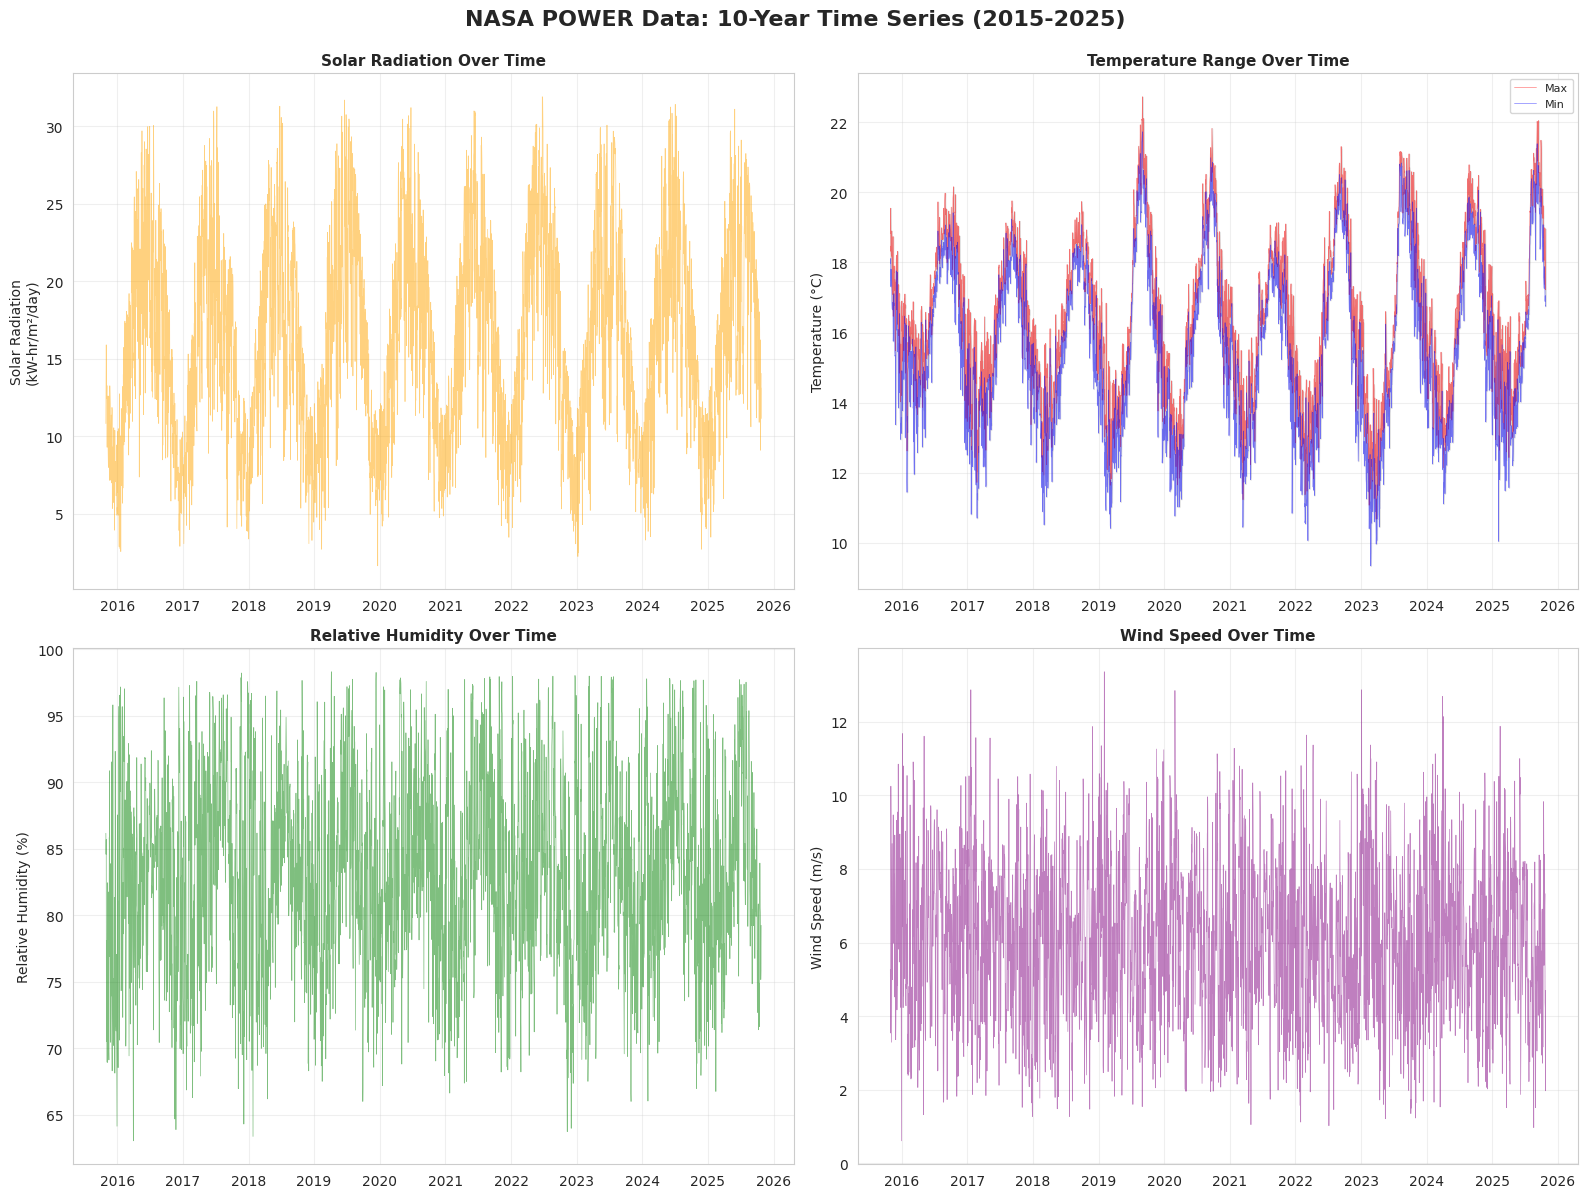

Key Observations:
  ✓ Clear seasonal patterns visible in all variables
  ✓ Solar radiation shows summer/winter variation
  ✓ Temperature exhibits annual cycles
  ✓ Wind speed appears more variable


In [9]:
# Time series visualization of key variables
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('NASA POWER Data: 10-Year Time Series (2015-2025)', fontsize=16, fontweight='bold', y=0.995)

# Solar radiation
axes[0, 0].plot(df_clean['date'], df_clean['ALLSKY_SFC_SW_DWN'], alpha=0.5, linewidth=0.5, color='orange')
axes[0, 0].set_ylabel('Solar Radiation\n(kW-hr/m²/day)', fontsize=10)
axes[0, 0].set_title('Solar Radiation Over Time', fontsize=11, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# Temperature
axes[0, 1].plot(df_clean['date'], df_clean['T2M_MAX'], alpha=0.5, linewidth=0.5, color='red', label='Max')
axes[0, 1].plot(df_clean['date'], df_clean['T2M_MIN'], alpha=0.5, linewidth=0.5, color='blue', label='Min')
axes[0, 1].fill_between(df_clean['date'], df_clean['T2M_MIN'], df_clean['T2M_MAX'], alpha=0.2, color='gray')
axes[0, 1].set_ylabel('Temperature (°C)', fontsize=10)
axes[0, 1].set_title('Temperature Range Over Time', fontsize=11, fontweight='bold')
axes[0, 1].legend(loc='upper right', fontsize=8)
axes[0, 1].grid(alpha=0.3)

# Humidity
axes[1, 0].plot(df_clean['date'], df_clean['RH2M'], alpha=0.5, linewidth=0.5, color='green')
axes[1, 0].set_ylabel('Relative Humidity (%)', fontsize=10)
axes[1, 0].set_title('Relative Humidity Over Time', fontsize=11, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Wind speed
axes[1, 1].plot(df_clean['date'], df_clean['WS2M'], alpha=0.5, linewidth=0.5, color='purple')
axes[1, 1].set_ylabel('Wind Speed (m/s)', fontsize=10)
axes[1, 1].set_title('Wind Speed Over Time', fontsize=11, fontweight='bold')
axes[1, 1].grid(alpha=0.3)


plt.tight_layout()
plt.show()

print("Key Observations:")
print("  ✓ Clear seasonal patterns visible in all variables")
print("  ✓ Solar radiation shows summer/winter variation")
print("  ✓ Temperature exhibits annual cycles")
print("  ✓ Wind speed appears more variable")

### Monthly and Seasonal Patterns

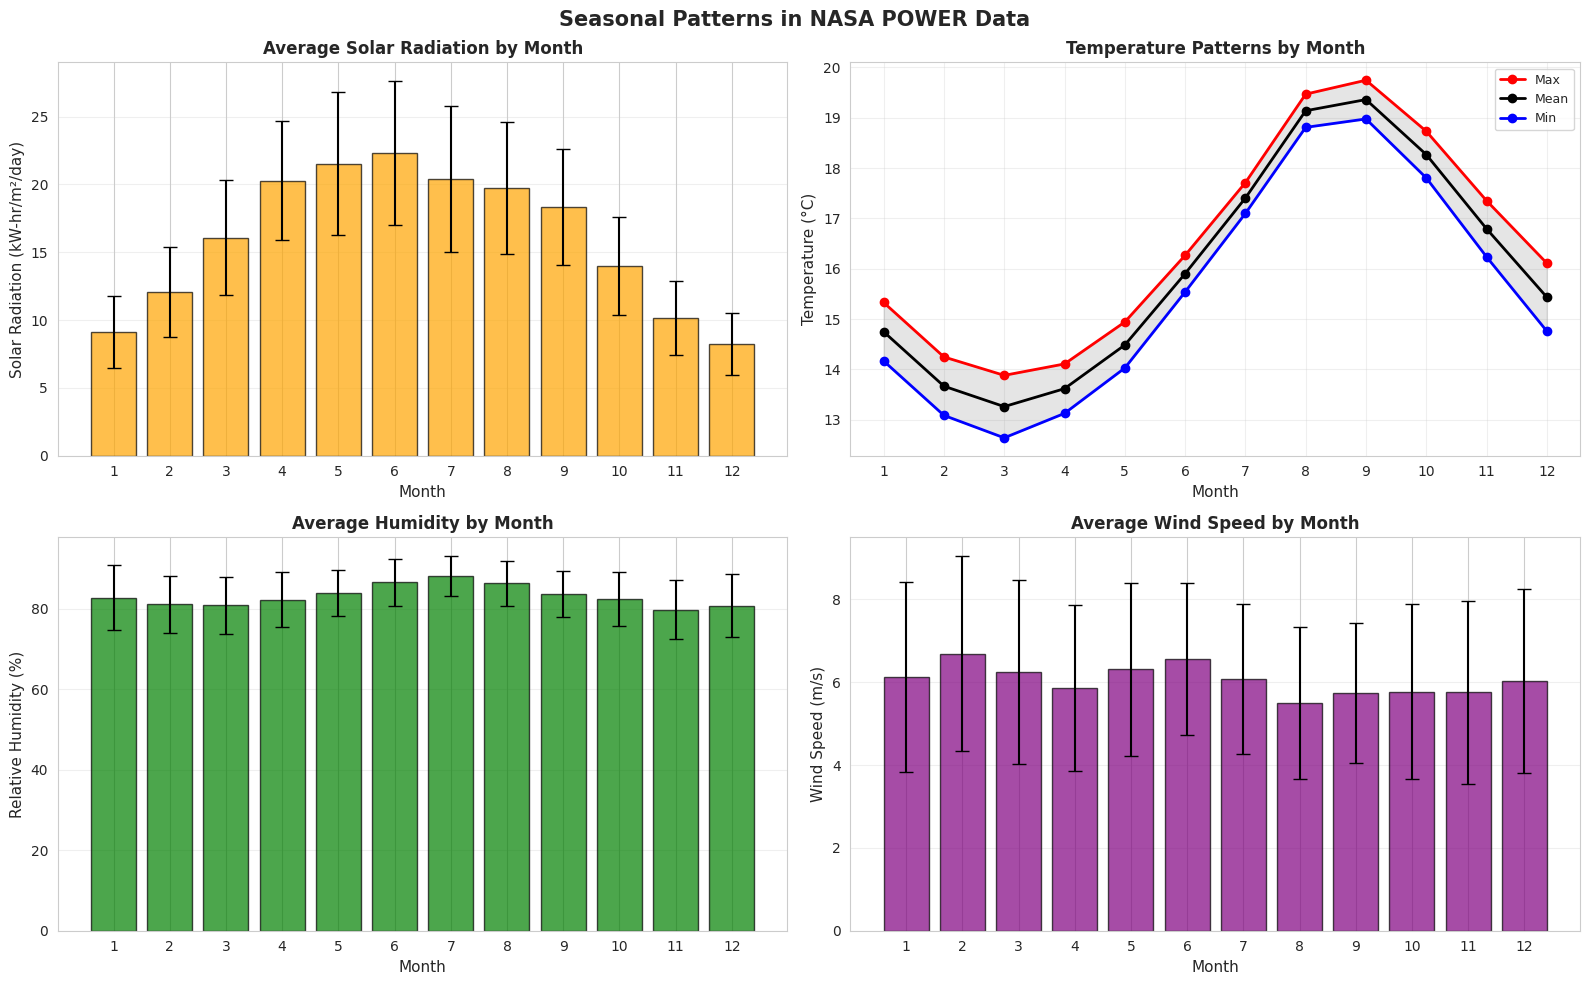

In [10]:
# Monthly patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Seasonal Patterns in NASA POWER Data', fontsize=15, fontweight='bold')

# Solar radiation by month
monthly_solar = df_clean.groupby('month')['ALLSKY_SFC_SW_DWN'].agg(['mean', 'std'])
axes[0, 0].bar(monthly_solar.index, monthly_solar['mean'], yerr=monthly_solar['std'],
               color='orange', alpha=0.7, edgecolor='black', capsize=5)
axes[0, 0].set_xlabel('Month', fontsize=11)
axes[0, 0].set_ylabel('Solar Radiation (kW-hr/m²/day)', fontsize=11)
axes[0, 0].set_title('Average Solar Radiation by Month', fontsize=12, fontweight='bold')
axes[0, 0].set_xticks(range(1, 13))
axes[0, 0].grid(axis='y', alpha=0.3)

# Temperature by month
monthly_temp = df_clean.groupby('month')[['T2M_MAX', 'T2M_MIN', 'T2M_MEAN']].mean()
x = monthly_temp.index
axes[0, 1].plot(x, monthly_temp['T2M_MAX'], 'o-', color='red', linewidth=2, label='Max', markersize=6)
axes[0, 1].plot(x, monthly_temp['T2M_MEAN'], 'o-', color='black', linewidth=2, label='Mean', markersize=6)
axes[0, 1].plot(x, monthly_temp['T2M_MIN'], 'o-', color='blue', linewidth=2, label='Min', markersize=6)
axes[0, 1].fill_between(x, monthly_temp['T2M_MIN'], monthly_temp['T2M_MAX'], alpha=0.2, color='gray')
axes[0, 1].set_xlabel('Month', fontsize=11)
axes[0, 1].set_ylabel('Temperature (°C)', fontsize=11)
axes[0, 1].set_title('Temperature Patterns by Month', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(range(1, 13))
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(alpha=0.3)

# Humidity by month
monthly_humidity = df_clean.groupby('month')['RH2M'].agg(['mean', 'std'])
axes[1, 0].bar(monthly_humidity.index, monthly_humidity['mean'], yerr=monthly_humidity['std'],
               color='green', alpha=0.7, edgecolor='black', capsize=5)
axes[1, 0].set_xlabel('Month', fontsize=11)
axes[1, 0].set_ylabel('Relative Humidity (%)', fontsize=11)
axes[1, 0].set_title('Average Humidity by Month', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].grid(axis='y', alpha=0.3)

# Wind speed by month
monthly_wind = df_clean.groupby('month')['WS2M'].agg(['mean', 'std'])
axes[1, 1].bar(monthly_wind.index, monthly_wind['mean'], yerr=monthly_wind['std'],
               color='purple', alpha=0.7, edgecolor='black', capsize=5)
axes[1, 1].set_xlabel('Month', fontsize=11)
axes[1, 1].set_ylabel('Wind Speed (m/s)', fontsize=11)
axes[1, 1].set_title('Average Wind Speed by Month', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(range(1, 13))
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

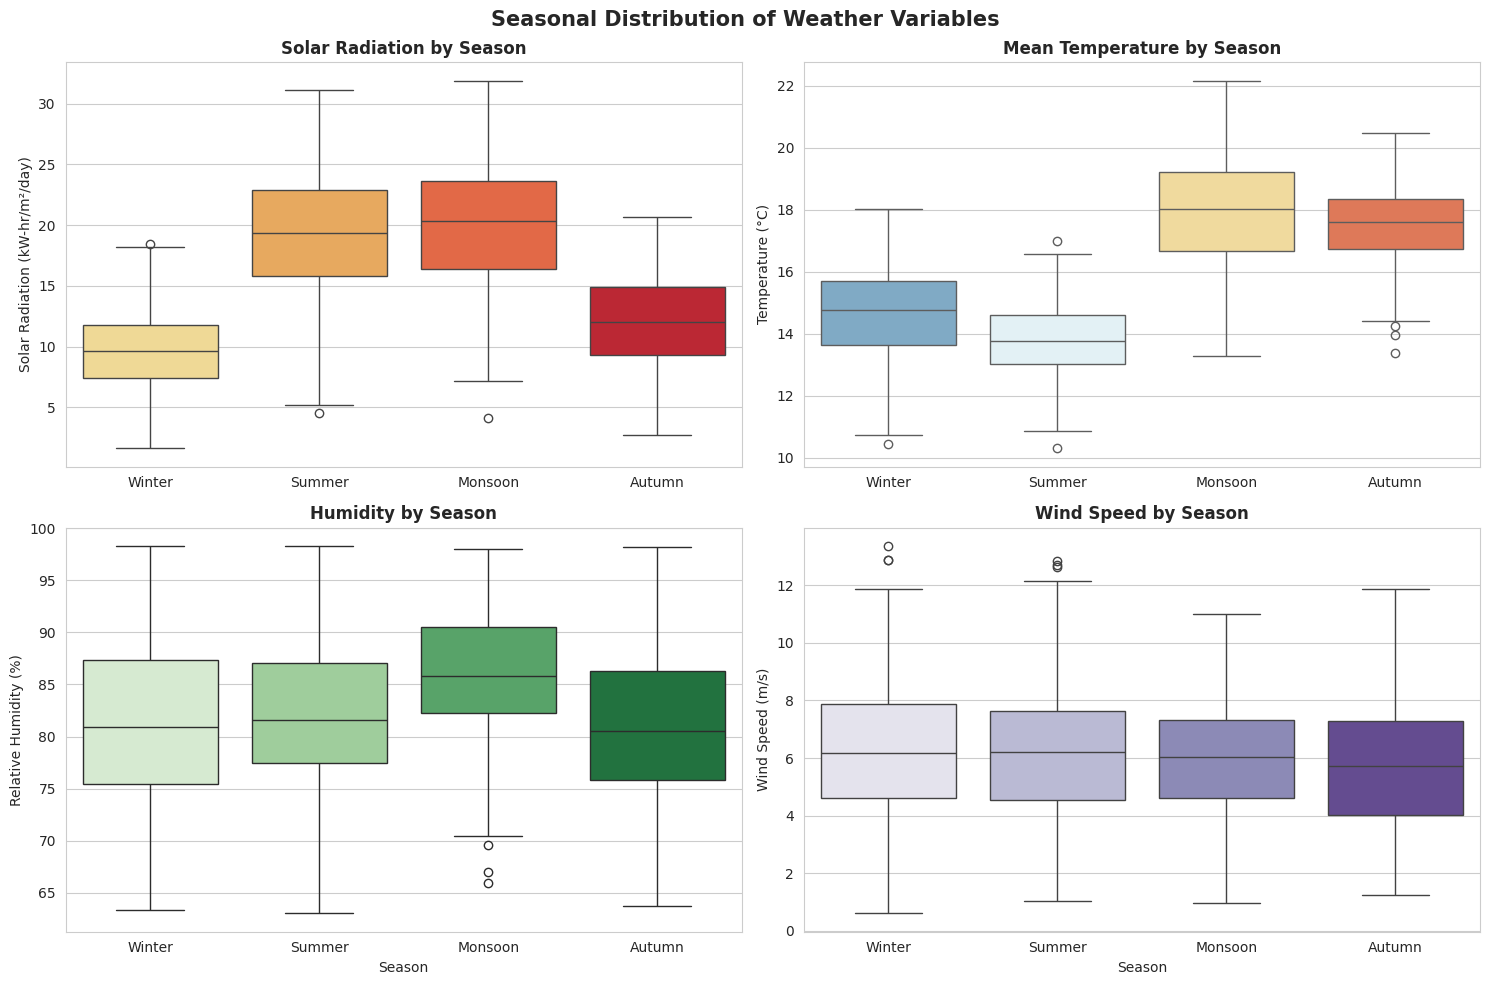

In [11]:
# Box plots by season
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Seasonal Distribution of Weather Variables', fontsize=15, fontweight='bold')

season_order = ['Winter', 'Summer', 'Monsoon', 'Autumn']

sns.boxplot(data=df_clean, x='season', y='ALLSKY_SFC_SW_DWN', order=season_order,
            ax=axes[0, 0], palette='YlOrRd')
axes[0, 0].set_title('Solar Radiation by Season', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Solar Radiation (kW-hr/m²/day)', fontsize=10)
axes[0, 0].set_xlabel('')

sns.boxplot(data=df_clean, x='season', y='T2M_MEAN', order=season_order,
            ax=axes[0, 1], palette='RdYlBu_r')
axes[0, 1].set_title('Mean Temperature by Season', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Temperature (°C)', fontsize=10)
axes[0, 1].set_xlabel('')

sns.boxplot(data=df_clean, x='season', y='RH2M', order=season_order,
            ax=axes[1, 0], palette='Greens')
axes[1, 0].set_title('Humidity by Season', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Relative Humidity (%)', fontsize=10)
axes[1, 0].set_xlabel('Season', fontsize=10)

sns.boxplot(data=df_clean, x='season', y='WS2M', order=season_order,
            ax=axes[1, 1], palette='Purples')
axes[1, 1].set_title('Wind Speed by Season', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Wind Speed (m/s)', fontsize=10)
axes[1, 1].set_xlabel('Season', fontsize=10)

plt.tight_layout()
plt.show()



### Distribution Analysis

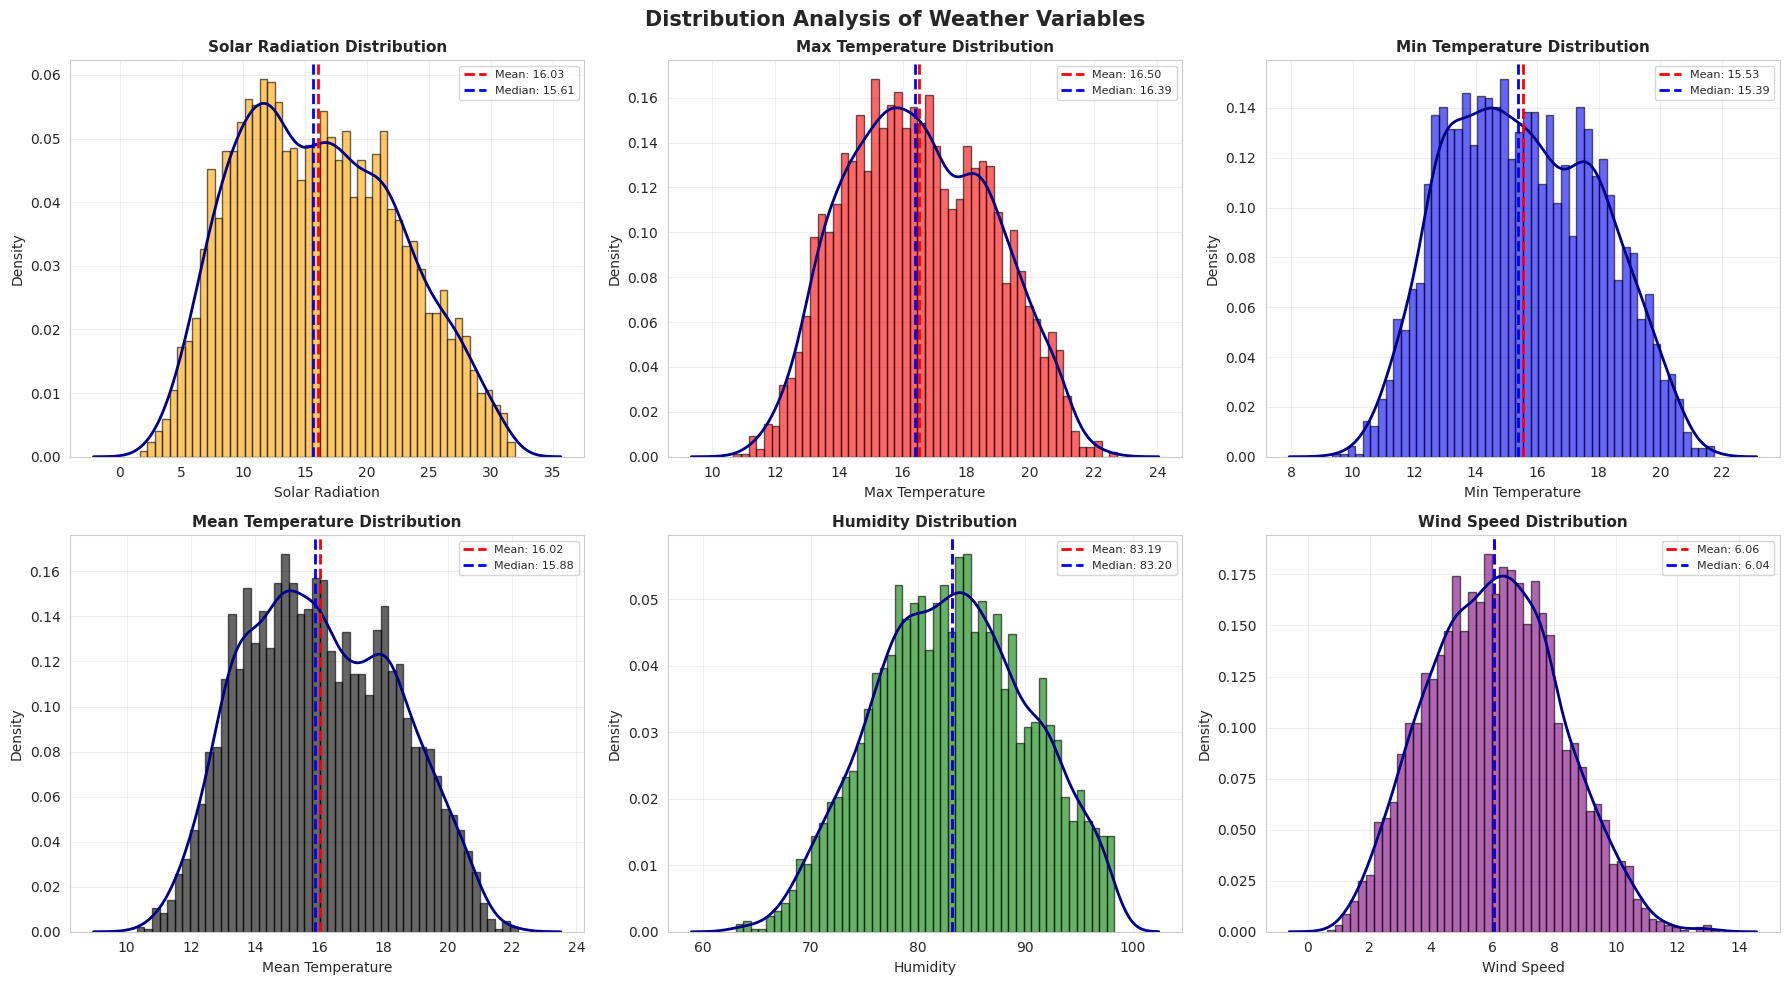

Most variables show reasonably normal-like distributions


In [12]:
# Distribution plots with statistical tests
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distribution Analysis of Weather Variables', fontsize=15, fontweight='bold')

variables = ['ALLSKY_SFC_SW_DWN', 'T2M_MAX', 'T2M_MIN', 'T2M_MEAN', 'RH2M', 'WS2M']
colors = ['orange', 'red', 'blue', 'black', 'green', 'purple']
titles = ['Solar Radiation', 'Max Temperature', 'Min Temperature',
          'Mean Temperature', 'Humidity', 'Wind Speed']

for idx, (var, color, title) in enumerate(zip(variables, colors, titles)):
    ax = axes[idx // 3, idx % 3]

    ax.hist(df_clean[var], bins=50, alpha=0.6, color=color, edgecolor='black', density=True)
    sns.kdeplot(df_clean[var], ax=ax, color='darkblue', linewidth=2)

    mean_val = df_clean[var].mean()
    median_val = df_clean[var].median()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    ax.axvline(median_val, color='blue', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')

    ax.set_xlabel(title, fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.set_title(f'{title} Distribution', fontsize=11, fontweight='bold')
    ax.legend(fontsize=8, loc='upper right')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Most variables show reasonably normal-like distributions")

### Correlation Analysis

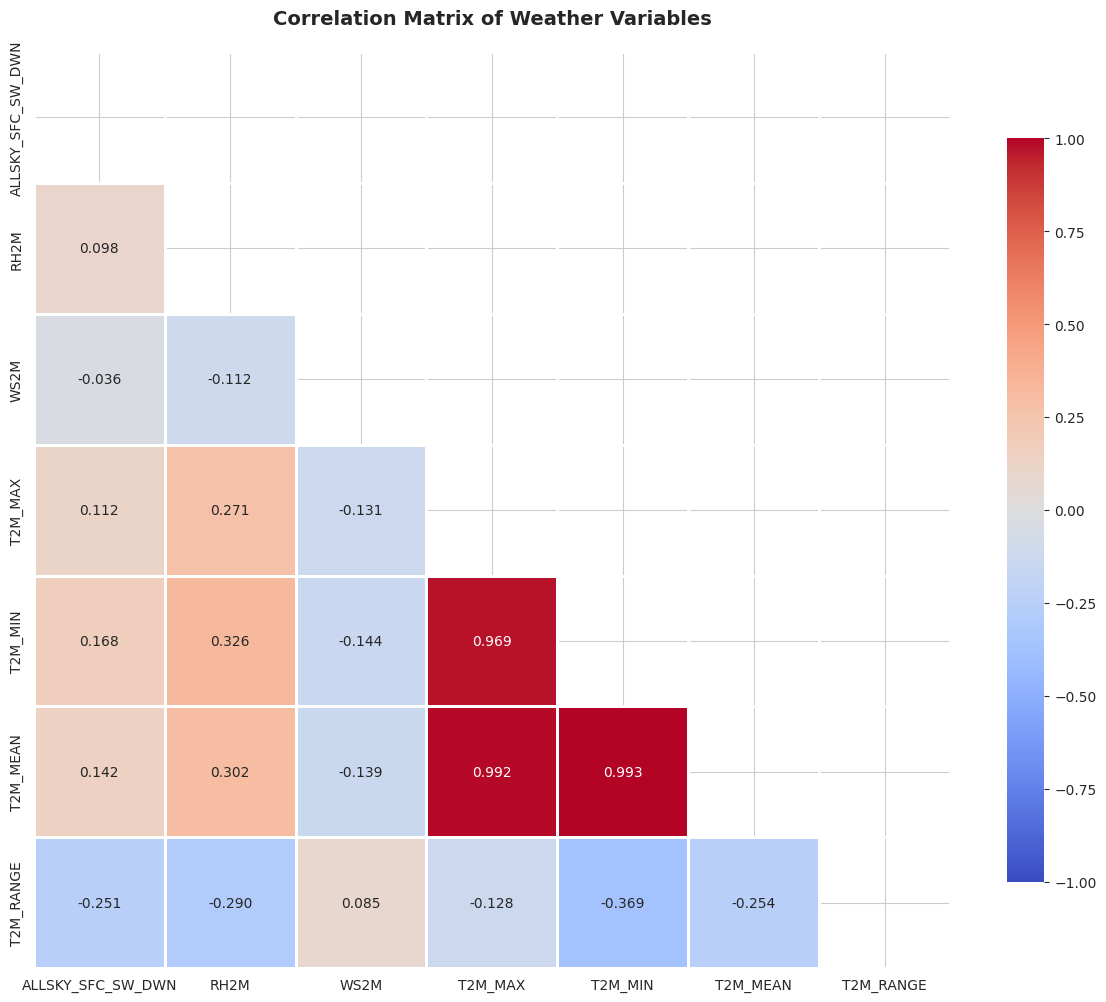


Key Correlations:
  T2M_MIN ↔ T2M_MEAN: 0.993
  T2M_MAX ↔ T2M_MEAN: 0.992
  T2M_MAX ↔ T2M_MIN: 0.969
  T2M_MIN ↔ T2M_RANGE: -0.369
  RH2M ↔ T2M_MIN: 0.326


In [13]:
# Correlation matrix
correlation_vars = ['ALLSKY_SFC_SW_DWN', 'RH2M', 'WS2M', 'T2M_MAX', 'T2M_MIN', 'T2M_MEAN', 'T2M_RANGE']
corr_matrix = df_clean[correlation_vars].corr()

# Plot correlation heatmap
fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.3f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, ax=ax)
ax.set_title('Correlation Matrix of Weather Variables', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nKey Correlations:")
# Find strongest correlations
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_pairs.append((
            corr_matrix.columns[i],
            corr_matrix.columns[j],
            corr_matrix.iloc[i, j]
        ))

corr_pairs_sorted = sorted(corr_pairs, key=lambda x: abs(x[2]), reverse=True)
for var1, var2, corr in corr_pairs_sorted[:5]:
    print(f"  {var1} ↔ {var2}: {corr:.3f}")

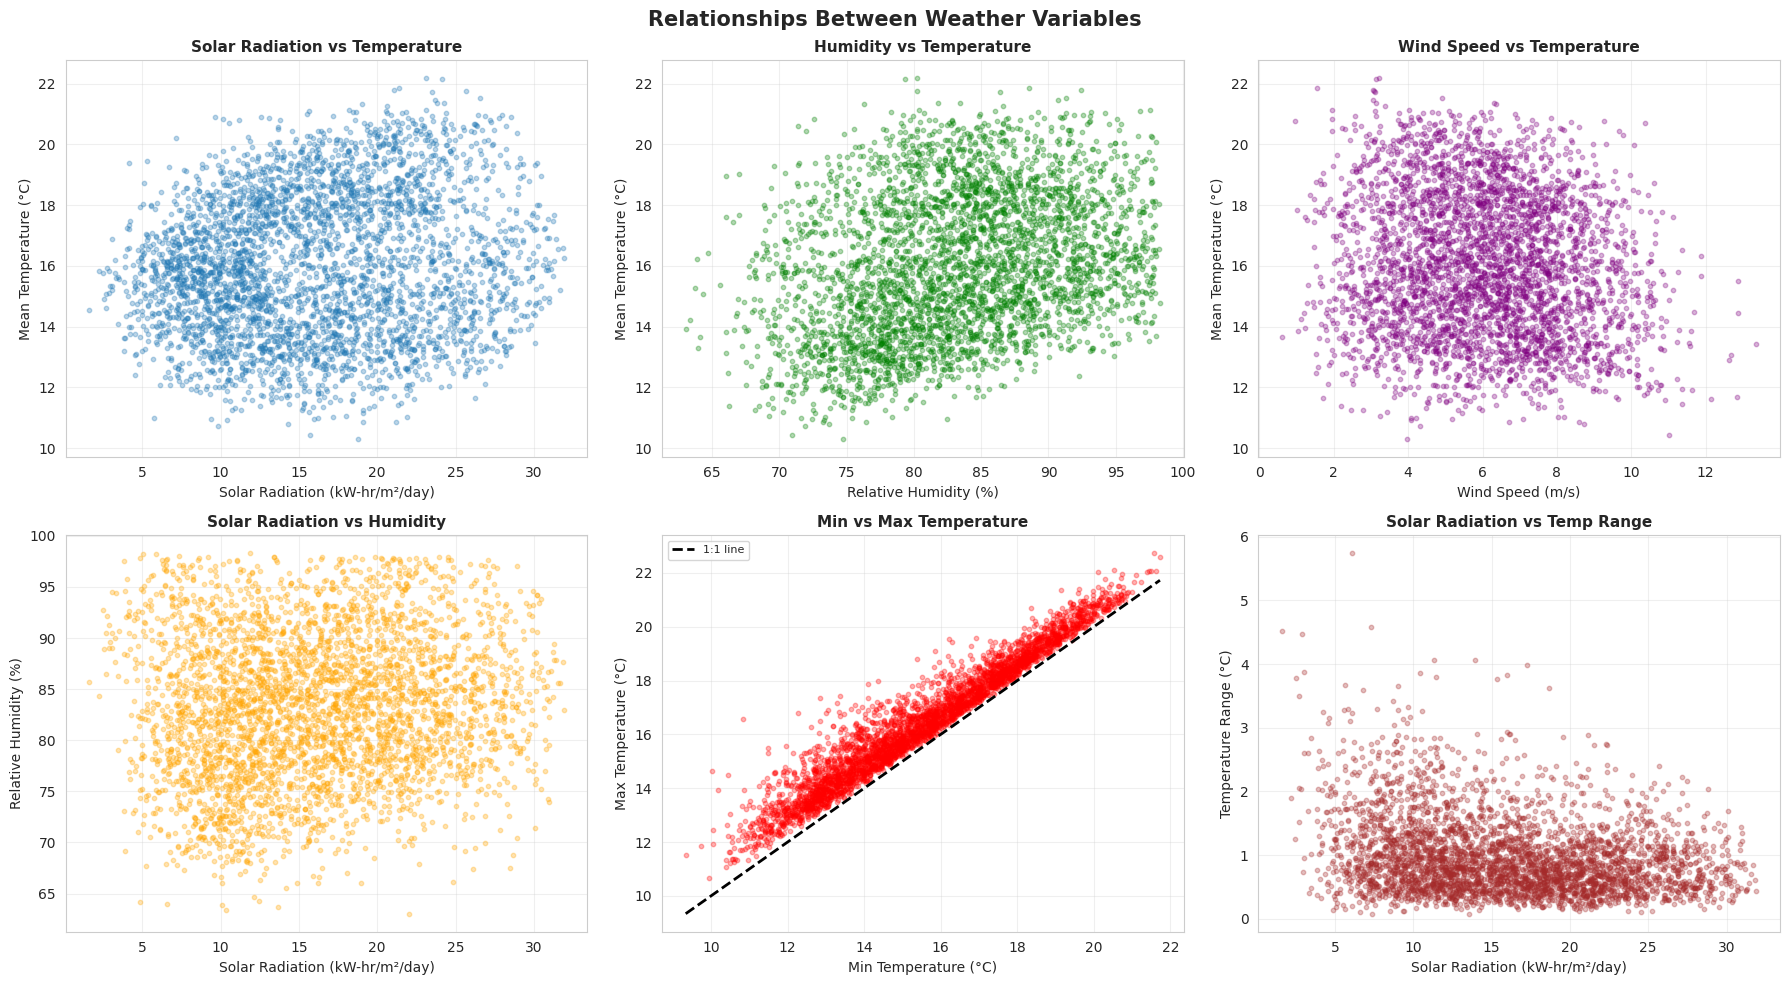

In [14]:
# Scatter plots for key relationships
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Relationships Between Weather Variables', fontsize=15, fontweight='bold')

# Solar radiation vs Temperature
axes[0, 0].scatter(df_clean['ALLSKY_SFC_SW_DWN'], df_clean['T2M_MEAN'], alpha=0.3, s=10)
axes[0, 0].set_xlabel('Solar Radiation (kW-hr/m²/day)', fontsize=10)
axes[0, 0].set_ylabel('Mean Temperature (°C)', fontsize=10)
axes[0, 0].set_title('Solar Radiation vs Temperature', fontsize=11, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# Humidity vs Temperature
axes[0, 1].scatter(df_clean['RH2M'], df_clean['T2M_MEAN'], alpha=0.3, s=10, color='green')
axes[0, 1].set_xlabel('Relative Humidity (%)', fontsize=10)
axes[0, 1].set_ylabel('Mean Temperature (°C)', fontsize=10)
axes[0, 1].set_title('Humidity vs Temperature', fontsize=11, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Wind vs Temperature
axes[0, 2].scatter(df_clean['WS2M'], df_clean['T2M_MEAN'], alpha=0.3, s=10, color='purple')
axes[0, 2].set_xlabel('Wind Speed (m/s)', fontsize=10)
axes[0, 2].set_ylabel('Mean Temperature (°C)', fontsize=10)
axes[0, 2].set_title('Wind Speed vs Temperature', fontsize=11, fontweight='bold')
axes[0, 2].grid(alpha=0.3)

# Solar vs Humidity
axes[1, 0].scatter(df_clean['ALLSKY_SFC_SW_DWN'], df_clean['RH2M'], alpha=0.3, s=10, color='orange')
axes[1, 0].set_xlabel('Solar Radiation (kW-hr/m²/day)', fontsize=10)
axes[1, 0].set_ylabel('Relative Humidity (%)', fontsize=10)
axes[1, 0].set_title('Solar Radiation vs Humidity', fontsize=11, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Max vs Min Temperature
axes[1, 1].scatter(df_clean['T2M_MIN'], df_clean['T2M_MAX'], alpha=0.3, s=10, color='red')
axes[1, 1].plot([df_clean['T2M_MIN'].min(), df_clean['T2M_MIN'].max()],
                [df_clean['T2M_MIN'].min(), df_clean['T2M_MIN'].max()],
                'k--', linewidth=2, label='1:1 line')
axes[1, 1].set_xlabel('Min Temperature (°C)', fontsize=10)
axes[1, 1].set_ylabel('Max Temperature (°C)', fontsize=10)
axes[1, 1].set_title('Min vs Max Temperature', fontsize=11, fontweight='bold')
axes[1, 1].legend(fontsize=8)
axes[1, 1].grid(alpha=0.3)

# Temperature range vs Solar radiation
axes[1, 2].scatter(df_clean['ALLSKY_SFC_SW_DWN'], df_clean['T2M_RANGE'], alpha=0.3, s=10, color='brown')
axes[1, 2].set_xlabel('Solar Radiation (kW-hr/m²/day)', fontsize=10)
axes[1, 2].set_ylabel('Temperature Range (°C)', fontsize=10)
axes[1, 2].set_title('Solar Radiation vs Temp Range', fontsize=11, fontweight='bold')
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Calculate ET₀ (Evapotranspiration)

The simplified FAO Penman-Monteith equation is commonly expressed as:

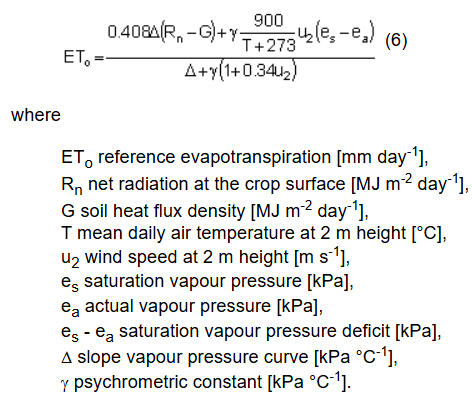

ET₀ is the **gold standard** for estimating water requirements in agriculture.


In [15]:
def calculate_et0_nasa(solar_rad, temp_mean, temp_max, temp_min, humidity, wind_speed):
    # Convert solar radiation to MJ/m²/day (1 kW-hr/m²/day = 3.6 MJ/m²/day)
    solar_rad_mj = solar_rad * 3.6

    # Saturation vapor pressure (kPa)
    es_max = 0.6108 * np.exp((17.27 * temp_max) / (temp_max + 237.3))
    es_min = 0.6108 * np.exp((17.27 * temp_min) / (temp_min + 237.3))
    es = (es_max + es_min) / 2

    # Actual vapor pressure (kPa)
    ea = es * (humidity / 100)

    # Vapor pressure deficit
    vpd = es - ea

    # Slope of saturation vapor pressure curve (kPa/°C)
    delta = 4098 * (0.6108 * np.exp((17.27 * temp_mean) / (temp_mean + 237.3))) / ((temp_mean + 237.3) ** 2)

    # Psychrometric constant (kPa/°C) - assuming elevation ~0m
    gamma = 0.665 * 0.001 * 101.3

    # Net radiation (simplified - using 75% of solar radiation)
    rn = solar_rad_mj * 0.75

    # Soil heat flux (assumed negligible for daily calc)
    g = 0

    # Wind speed adjustment factor
    u2 = wind_speed  # Already at 2m

    # FAO Penman-Monteith equation (simplified)
    numerator = 0.408 * delta * (rn - g) + gamma * (900 / (temp_mean + 273)) * u2 * vpd
    denominator = delta + gamma * (1 + 0.34 * u2)

    et0 = numerator / denominator

    return max(0, et0)

df_clean['ET0'] = df_clean.apply(lambda row: calculate_et0_nasa(
    row['ALLSKY_SFC_SW_DWN'],
    row['T2M_MEAN'],
    row['T2M_MAX'],
    row['T2M_MIN'],
    row['RH2M'],
    row['WS2M']
), axis=1)

print("ET0 (Reference Evapotranspiration) calculated using FAO Penman-Monteith method")
print("\nET0 Statistics:")
print(f"Mean: {df_clean['ET0'].mean():.3f} mm/day")
print(f"Median: {df_clean['ET0'].median():.3f} mm/day")
print(f"Std: {df_clean['ET0'].std():.3f} mm/day")
print(f"Min: {df_clean['ET0'].min():.3f} mm/day")
print(f"Max: {df_clean['ET0'].max():.3f} mm/day")
print(f"\nAnnual ET0 would be: {df_clean['ET0'].mean() * 365:.0f} mm/year")

ET0 (Reference Evapotranspiration) calculated using FAO Penman-Monteith method

ET0 Statistics:
Mean: 7.726 mm/day
Median: 7.323 mm/day
Std: 2.917 mm/day
Min: 1.427 mm/day
Max: 18.685 mm/day

Annual ET0 would be: 2820 mm/year


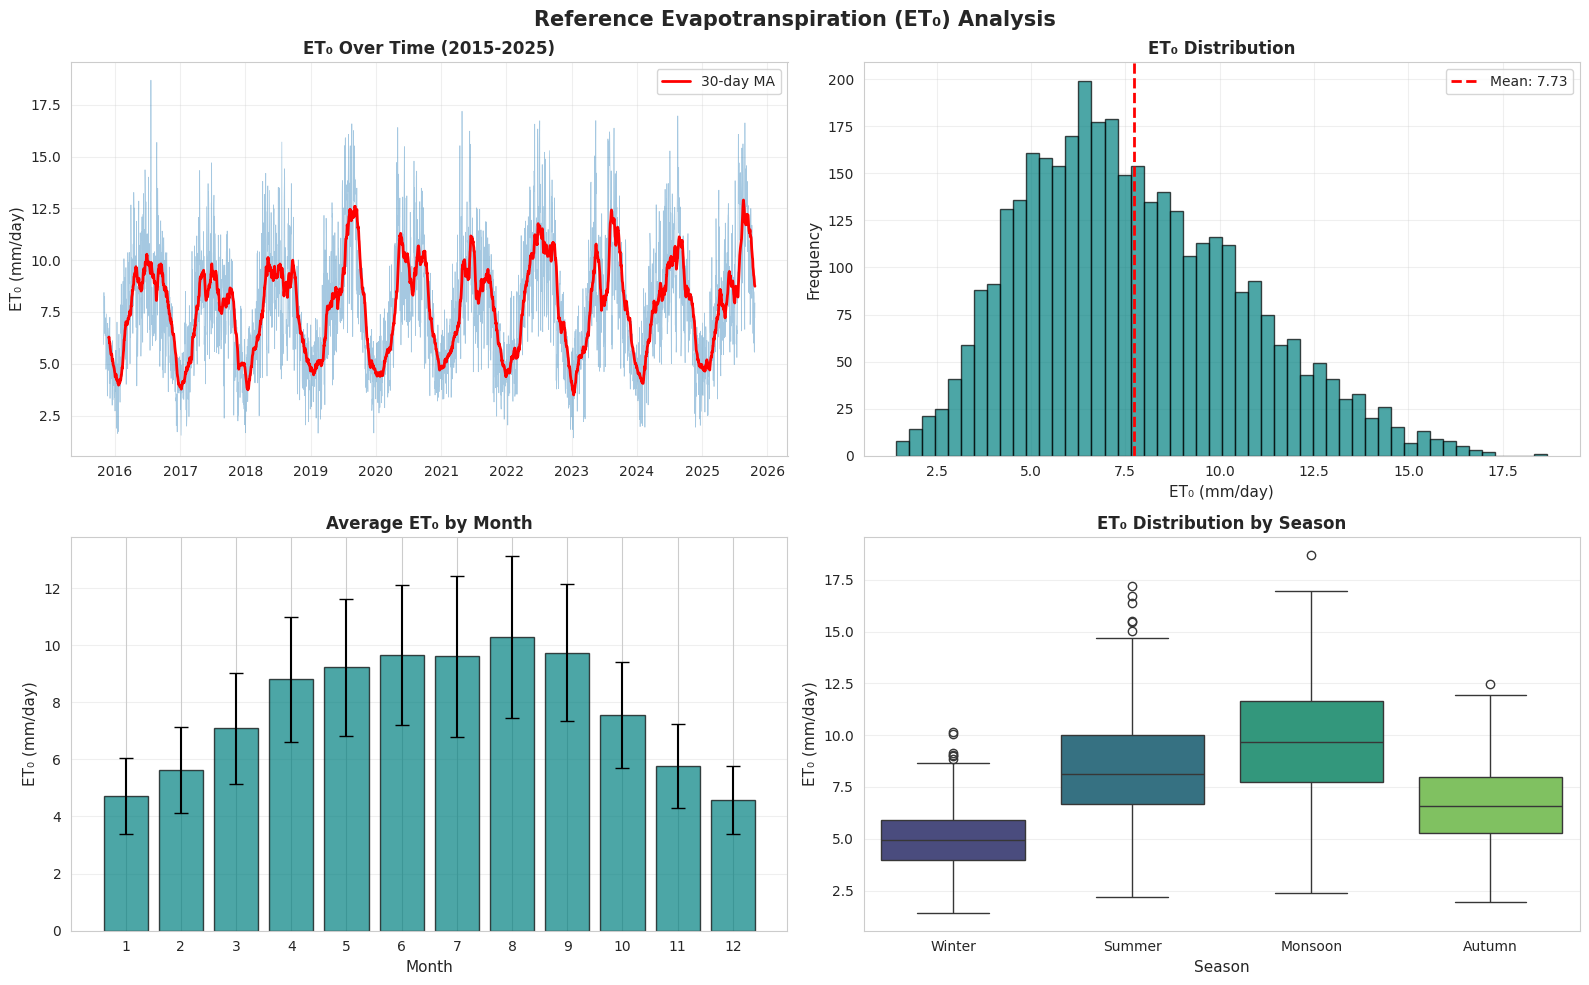


Seasonal ET0 Summary:
          count   mean    std    min    25%    50%     75%     max
season                                                            
Autumn    605.0  6.672  1.896  1.940  5.288  6.599   7.965  12.494
Monsoon  1220.0  9.818  2.648  2.375  7.759  9.687  11.650  18.685
Summer    920.0  8.365  2.373  2.209  6.680  8.106  10.013  17.188
Winter    903.0  4.955  1.419  1.427  3.983  4.937   5.910  10.134


In [16]:

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Reference Evapotranspiration (ET₀) Analysis', fontsize=15, fontweight='bold')

axes[0, 0].plot(df_clean['date'], df_clean['ET0'], alpha=0.4, linewidth=0.5)
axes[0, 0].plot(df_clean['date'], df_clean['ET0'].rolling(30).mean(),
                color='red', linewidth=2, label='30-day MA')
axes[0, 0].set_ylabel('ET₀ (mm/day)', fontsize=11)
axes[0, 0].set_title('ET₀ Over Time (2015-2025)', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

axes[0, 1].hist(df_clean['ET0'], bins=50, color='teal', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(df_clean['ET0'].mean(), color='red', linestyle='--',
                   linewidth=2, label=f"Mean: {df_clean['ET0'].mean():.2f}")
axes[0, 1].set_xlabel('ET₀ (mm/day)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('ET₀ Distribution', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

monthly_et0 = df_clean.groupby('month')['ET0'].agg(['mean', 'std'])
axes[1, 0].bar(monthly_et0.index, monthly_et0['mean'], yerr=monthly_et0['std'],
               color='teal', alpha=0.7, edgecolor='black', capsize=5)
axes[1, 0].set_xlabel('Month', fontsize=11)
axes[1, 0].set_ylabel('ET₀ (mm/day)', fontsize=11)
axes[1, 0].set_title('Average ET₀ by Month', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].grid(axis='y', alpha=0.3)

sns.boxplot(data=df_clean, x='season', y='ET0',
            order=['Winter', 'Summer', 'Monsoon', 'Autumn'],
            ax=axes[1, 1], palette='viridis')
axes[1, 1].set_xlabel('Season', fontsize=11)
axes[1, 1].set_ylabel('ET₀ (mm/day)', fontsize=11)
axes[1, 1].set_title('ET₀ Distribution by Season', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nSeasonal ET0 Summary:")
print(df_clean.groupby('season')['ET0'].describe().round(3))

## Create Target Variable (Crop Water Requirement)

Dataset from FAO 56 journal - [Link](https://www.fao.org/4/x0490e/x0490e00.htm)

Formula:

image.png



In [17]:
# Crop coefficients (Kc) from FAO guidelines (FAO 56)
crop_database = {
    'Wheat': {'kc': 1.0, 'description': 'Winter cereal crop'},
    'Rice': {'kc': 1.2, 'description': 'Flooded paddy rice'},
    'Cotton': {'kc': 0.9, 'description': 'Fiber crop'},
    'Maize': {'kc': 0.95, 'description': 'Summer cereal'},
    'Sugarcane': {'kc': 1.25, 'description': 'Perennial sugar crop'},
    'Vegetables': {'kc': 0.85, 'description': 'Mixed vegetables'},
    'Fruits': {'kc': 0.80, 'description': 'Orchard fruits'}
}

# Create multi-crop dataset
crop_datasets = []

for crop_name, crop_info in crop_database.items():
    df_crop = df_clean.copy()
    df_crop['crop'] = crop_name
    df_crop['kc'] = crop_info['kc']
    df_crop['crop_water_req'] = df_crop['ET0'] * crop_info['kc']
    crop_datasets.append(df_crop)

# Combine all crops
df_full = pd.concat(crop_datasets, ignore_index=True)

print(f"Total records: {len(df_full):,}")
print(f"Crops: {len(crop_database)}, Days per crop: {len(df_clean):,}")

print("\nCrop Water Requirements:")
for crop, info in crop_database.items():
    avg_req = df_full[df_full['crop']==crop]['crop_water_req'].mean()
    print(f"{crop:12s} | Kc: {info['kc']:.2f} | Avg: {avg_req:.2f} mm/day")

Total records: 25,536
Crops: 7, Days per crop: 3,648

Crop Water Requirements:
Wheat        | Kc: 1.00 | Avg: 7.73 mm/day
Rice         | Kc: 1.20 | Avg: 9.27 mm/day
Cotton       | Kc: 0.90 | Avg: 6.95 mm/day
Maize        | Kc: 0.95 | Avg: 7.34 mm/day
Sugarcane    | Kc: 1.25 | Avg: 9.66 mm/day
Vegetables   | Kc: 0.85 | Avg: 6.57 mm/day
Fruits       | Kc: 0.80 | Avg: 6.18 mm/day


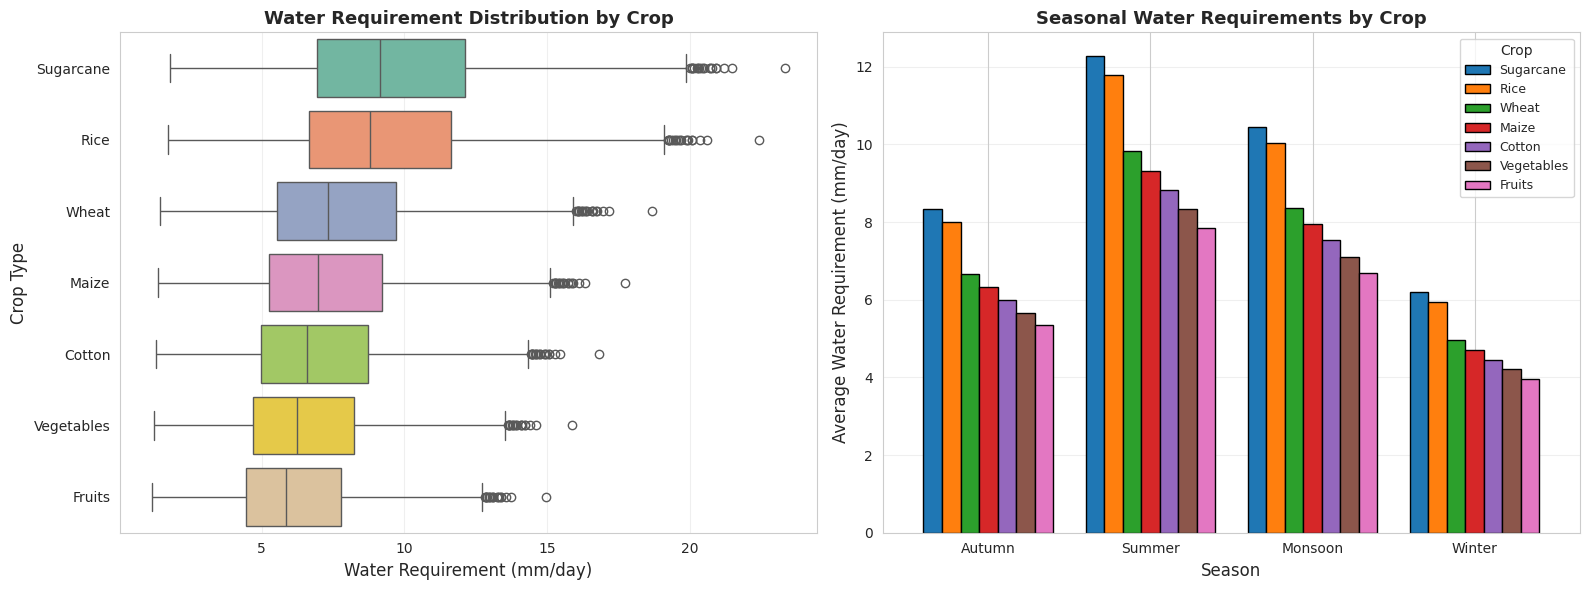

In [18]:
# Visualize crop water requirements
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box plot
crop_order = sorted(crop_database.keys(), key=lambda x: crop_database[x]['kc'], reverse=True)
sns.boxplot(data=df_full, y='crop', x='crop_water_req', order=crop_order,
            ax=axes[0], palette='Set2')
axes[0].set_xlabel('Water Requirement (mm/day)', fontsize=12)
axes[0].set_ylabel('Crop Type', fontsize=12)
axes[0].set_title('Water Requirement Distribution by Crop', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Seasonal variation by crop
seasonal_crop = df_full.groupby(['season', 'crop'])['crop_water_req'].mean().unstack()
seasonal_crop[crop_order].plot(kind='bar', ax=axes[1], width=0.8, edgecolor='black')
axes[1].set_xlabel('Season', fontsize=12)
axes[1].set_ylabel('Average Water Requirement (mm/day)', fontsize=12)
axes[1].set_title('Seasonal Water Requirements by Crop', fontsize=13, fontweight='bold')
axes[1].legend(title='Crop', fontsize=9, title_fontsize=10)
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xticklabels(['Autumn', 'Summer', 'Monsoon', 'Winter'], rotation=0)

plt.tight_layout()
plt.show()

## Prepare Data for ML

In [19]:
selected_features = [
    'ALLSKY_SFC_SW_DWN', # Solar radiation
    'T2M_MEAN',  # Temperature
    'T2M_MAX',  # Max temperature
    'T2M_MIN',  # Min temperature
    'RH2M',  # Humidity
    'WS2M',  # Wind speed
    'T2M_RANGE',  # Temperature range
    'month',  # Month of year
    'ET0',  # Evapotranspiration
    'kc'  # Crop coefficient
]

X = df_full[selected_features].copy()
y = df_full['crop_water_req'].copy()

print("Dataset Preparation:")
print(f"Features: {len(selected_features)}")
print(f"Total samples: {len(X):,}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

print(f"\nDataset Split:")
print(f"- Training: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"- Test: {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")

print(f"\nTarget variable statistics:")
print(f"- Mean: {y_train.mean():.3f} mm/day")
print(f"- Range: [{y_train.min():.3f}, {y_train.max():.3f}] mm/day")

Dataset Preparation:
Features: 10
Total samples: 25,536

Dataset Split:
- Training: 20,428 samples (80.0%)
- Test: 5,108 samples (20.0%)

Target variable statistics:
- Mean: 7.684 mm/day
- Range: [1.213, 22.423] mm/day


## Feature Scaling

In [20]:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Features scaled successfully")

Features scaled successfully


## Model Training and Comparison

In [21]:

models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(max_depth=10, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

print(f"Training {len(models)} models")
print(f"Training samples: {len(X_train_scaled):,}")

Training 4 models
Training samples: 20,428


In [22]:

results = []

for name, model in models.items():
    print(f"\nTraining: {name}")
    # Train the model
    start_time = pd.Timestamp.now()
    model.fit(X_train_scaled, y_train)
    train_time = (pd.Timestamp.now() - start_time).total_seconds()

    # Make predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # Calculate metrics
    train_r2 = r2_score(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))


    # Store results
    results.append({
        'Model': name,
        'Train_R2': train_r2,
        'Train_RMSE': train_rmse,
        'Test_R2': test_r2,
        'Test_RMSE': test_rmse,
        'Train_Time': train_time
    })

    print(f"  Training R²: {train_r2:.4f}")
    print(f"  Test R²: {test_r2:.4f}")
    print(f"  Test RMSE: {test_rmse:.4f} mm/day")

# Create results DataFrame
results_df = pd.DataFrame(results).sort_values('Test_R2', ascending=False).reset_index(drop=True)

print("\nMODEL COMPARISON - FINAL RESULTS")
print("\n")
print(results_df.to_string(index=False))
print("\nAll models trained successfully!")


Training: Linear Regression
  Training R²: 0.9787
  Test R²: 0.9786
  Test RMSE: 0.4674 mm/day

Training: Decision Tree
  Training R²: 0.9999
  Test R²: 0.9996
  Test RMSE: 0.0606 mm/day

Training: Random Forest
  Training R²: 1.0000
  Test R²: 0.9999
  Test RMSE: 0.0302 mm/day

Training: Gradient Boosting
  Training R²: 0.9996
  Test R²: 0.9996
  Test RMSE: 0.0660 mm/day

MODEL COMPARISON - FINAL RESULTS


            Model  Train_R2  Train_RMSE  Test_R2  Test_RMSE  Train_Time
    Random Forest  0.999992    0.009214 0.999911   0.030152   16.927620
    Decision Tree  0.999863    0.037141 0.999640   0.060627    0.235243
Gradient Boosting  0.999639    0.060361 0.999573   0.066035    5.108726
Linear Regression  0.978729    0.463184 0.978619   0.467350    0.029866

All models trained successfully!


## Model Performance Visualization

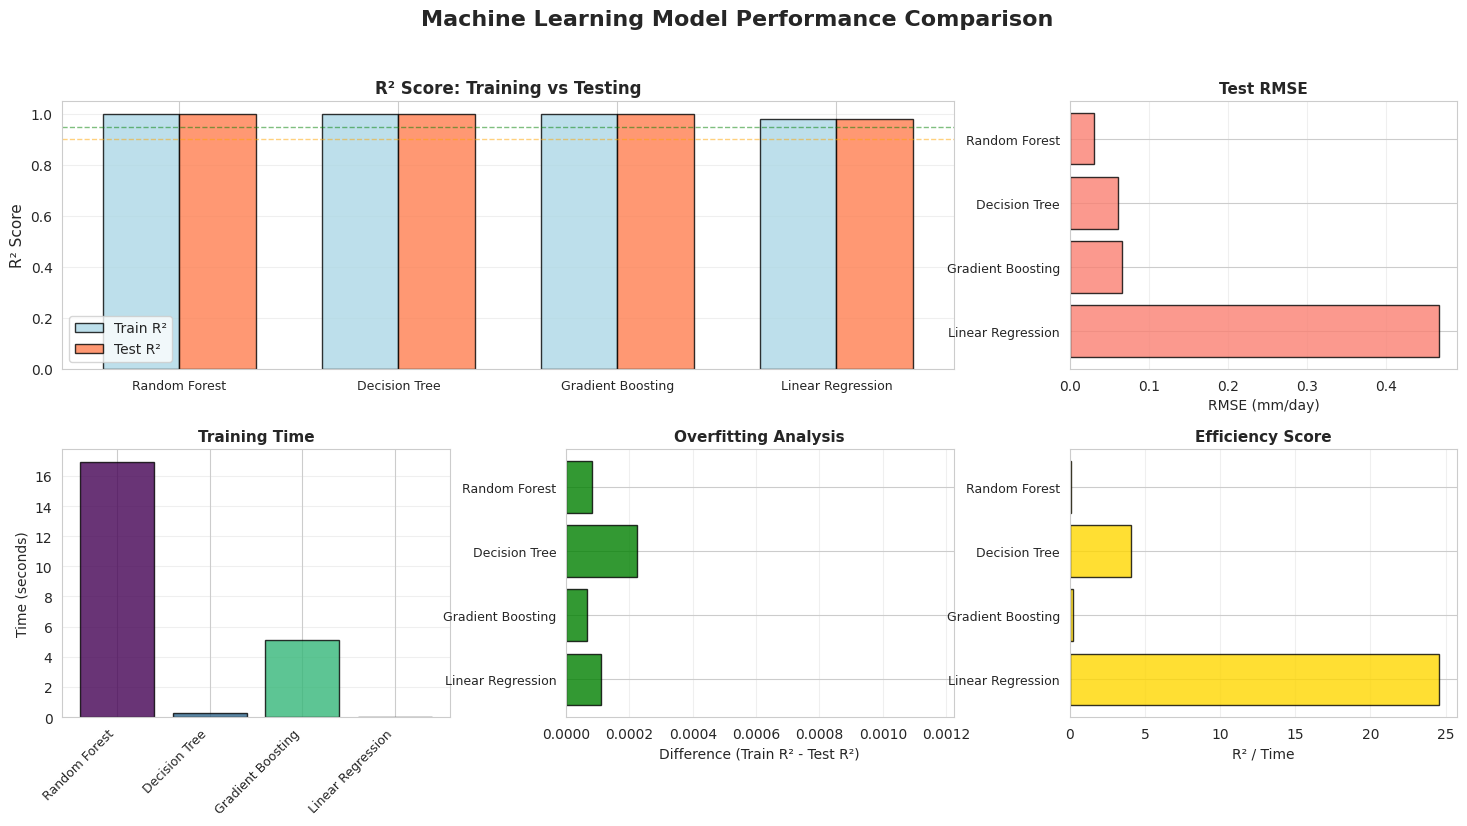


BEST MODEL (by Test R²): Random Forest
Test R²: 0.9999
Test RMSE: 0.0302 mm/day


In [35]:

fig = plt.figure(figsize=(18, 8))
gs = GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)

fig.suptitle('Machine Learning Model Performance Comparison', fontsize=16, fontweight='bold', y=0.995)

# 1. R² Score Comparison
ax1 = fig.add_subplot(gs[0, :2])
x_pos = np.arange(len(results_df))
width = 0.35
ax1.bar(x_pos - width/2, results_df['Train_R2'], width, label='Train R²',
        color='lightblue', edgecolor='black', alpha=0.8)
ax1.bar(x_pos + width/2, results_df['Test_R2'], width, label='Test R²',
        color='coral', edgecolor='black', alpha=0.8)
ax1.set_ylabel('R² Score', fontsize=11)
ax1.set_title('R² Score: Training vs Testing', fontsize=12, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(results_df['Model'], fontsize=9)
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=0.95, color='green', linestyle='--', linewidth=1, alpha=0.5, label='Excellent (>0.95)')
ax1.axhline(y=0.90, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='Good (>0.90)')

# 2. RMSE Comparison
ax2 = fig.add_subplot(gs[0, 2])
ax2.barh(range(len(results_df)), results_df['Test_RMSE'], color='salmon', edgecolor='black', alpha=0.8)
ax2.set_yticks(range(len(results_df)))
ax2.set_yticklabels(results_df['Model'], fontsize=9)
ax2.set_xlabel('RMSE (mm/day)', fontsize=10)
ax2.set_title('Test RMSE', fontsize=11, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

# 3. Training Time
ax3 = fig.add_subplot(gs[1, 0])
colors_time = plt.cm.viridis(np.linspace(0, 1, len(results_df)))
ax3.bar(range(len(results_df)), results_df['Train_Time'], color=colors_time, edgecolor='black', alpha=0.8)
ax3.set_xticks(range(len(results_df)))
ax3.set_xticklabels(results_df['Model'], rotation=45, ha='right', fontsize=9)
ax3.set_ylabel('Time (seconds)', fontsize=10)
ax3.set_title('Training Time', fontsize=11, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# 4. Overfitting Analysis (Train R² - Test R²)
ax4 = fig.add_subplot(gs[1, 1])
overfit_score = results_df['Train_R2'] - results_df['Test_R2']
colors_overfit = ['green' if x < 0.05 else 'orange' if x < 0.10 else 'red' for x in overfit_score]
ax4.barh(range(len(results_df)), overfit_score, color=colors_overfit, edgecolor='black', alpha=0.8)
ax4.set_yticks(range(len(results_df)))
ax4.set_yticklabels(results_df['Model'], fontsize=9)
ax4.set_xlabel('Difference (Train R² - Test R²)', fontsize=10)
ax4.set_xlim(0, max(overfit_score) + 0.001)
ax4.set_title('Overfitting Analysis', fontsize=11, fontweight='bold')
ax4.axvline(x=0.05, color='orange', linestyle='--', linewidth=1, alpha=0.5)
ax4.axvline(x=0.10, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax4.invert_yaxis()
ax4.grid(axis='x', alpha=0.3)

# 5. Efficiency Score (R² / Time)
ax5 = fig.add_subplot(gs[1, 2])
efficiency = results_df['Test_R2'] / (results_df['Train_Time'] + 0.01)
ax5.barh(range(len(results_df)), efficiency, color='gold', edgecolor='black', alpha=0.8)
ax5.set_yticks(range(len(results_df)))
ax5.set_yticklabels(results_df['Model'], fontsize=9)
ax5.set_xlabel('R² / Time', fontsize=10)
ax5.set_title('Efficiency Score', fontsize=11, fontweight='bold')
ax5.invert_yaxis()
ax5.grid(axis='x', alpha=0.3)

plt.show()


print(f"\nBEST MODEL (by Test R²): {results_df.iloc[0]['Model']}")
print(f"Test R²: {results_df.iloc[0]['Test_R2']:.4f}")
print(f"Test RMSE: {results_df.iloc[0]['Test_RMSE']:.4f} mm/day")


## Best Model Analysis

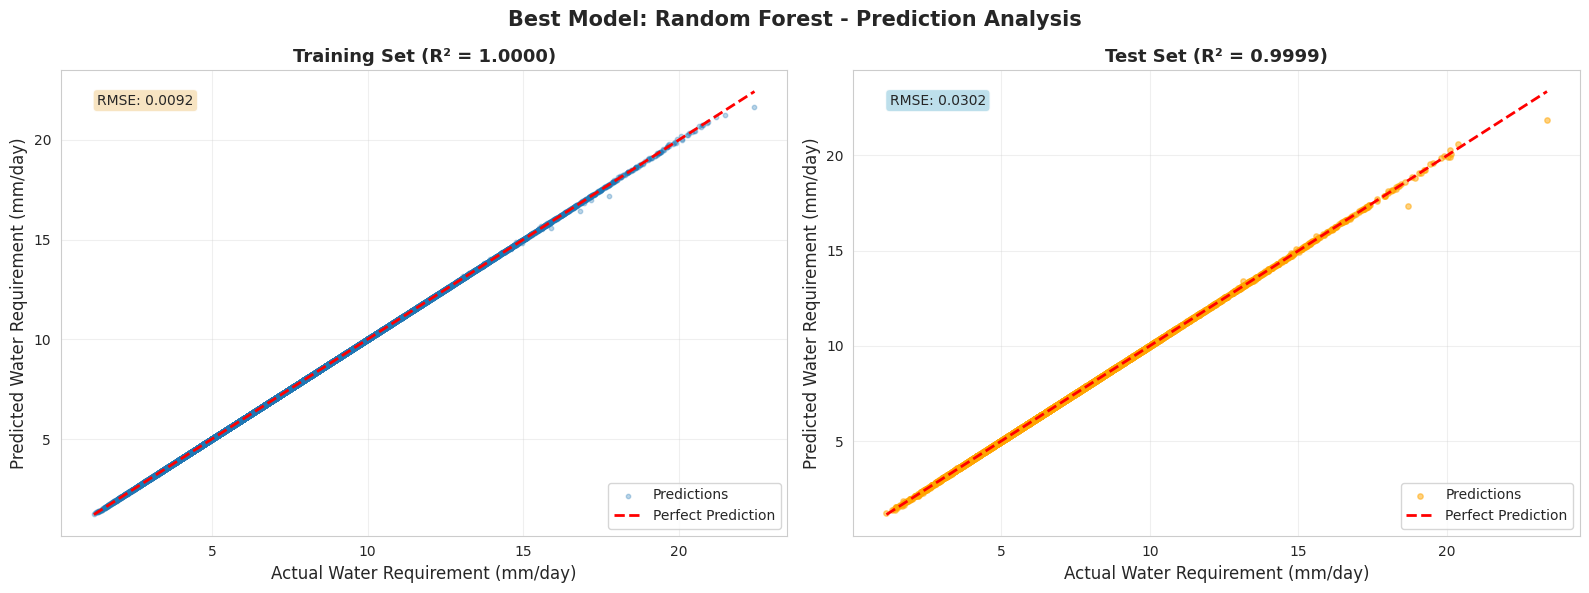

In [36]:

best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

y_train_pred_best = best_model.predict(X_train_scaled)
y_test_pred_best = best_model.predict(X_test_scaled)

# Prediction vs Actual plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(f'Best Model: {best_model_name} - Prediction Analysis', fontsize=15, fontweight='bold')

# Training set
axes[0].scatter(y_train, y_train_pred_best, alpha=0.3, s=10, label='Predictions')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Water Requirement (mm/day)', fontsize=12)
axes[0].set_ylabel('Predicted Water Requirement (mm/day)', fontsize=12)
axes[0].set_title(f'Training Set (R² = {results_df.iloc[0]["Train_R2"]:.4f})', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

train_stats_text = f"RMSE: {results_df.iloc[0]['Train_RMSE']:.4f}"
axes[0].text(0.05, 0.95, train_stats_text, transform=axes[0].transAxes,
            fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Testing set
axes[1].scatter(y_test, y_test_pred_best, alpha=0.5, s=15, color='orange', label='Predictions')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Water Requirement (mm/day)', fontsize=12)
axes[1].set_ylabel('Predicted Water Requirement (mm/day)', fontsize=12)
axes[1].set_title(f'Test Set (R² = {results_df.iloc[0]["Test_R2"]:.4f})', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

test_stats_text = f"RMSE: {results_df.iloc[0]['Test_RMSE']:.4f}"
axes[1].text(0.05, 0.95, test_stats_text, transform=axes[1].transAxes,
            fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

## Crop-Specific Performance


Model Performance by Crop Type:
      Crop  Test_Samples       R²     RMSE  Avg_Actual  Avg_Predicted
Vegetables           723 0.999992 0.006871    6.523621       6.523147
     Maize           723 0.999990 0.008728    7.239433       7.240166
    Cotton           752 0.999986 0.009825    6.992152       6.992757
      Rice           740 0.999977 0.016937    9.244861       9.248001
    Fruits           734 0.999969 0.012647    6.156452       6.158157
 Sugarcane           700 0.999766 0.057575    9.527721       9.522329
     Wheat           736 0.999711 0.049891    7.722682       7.719415


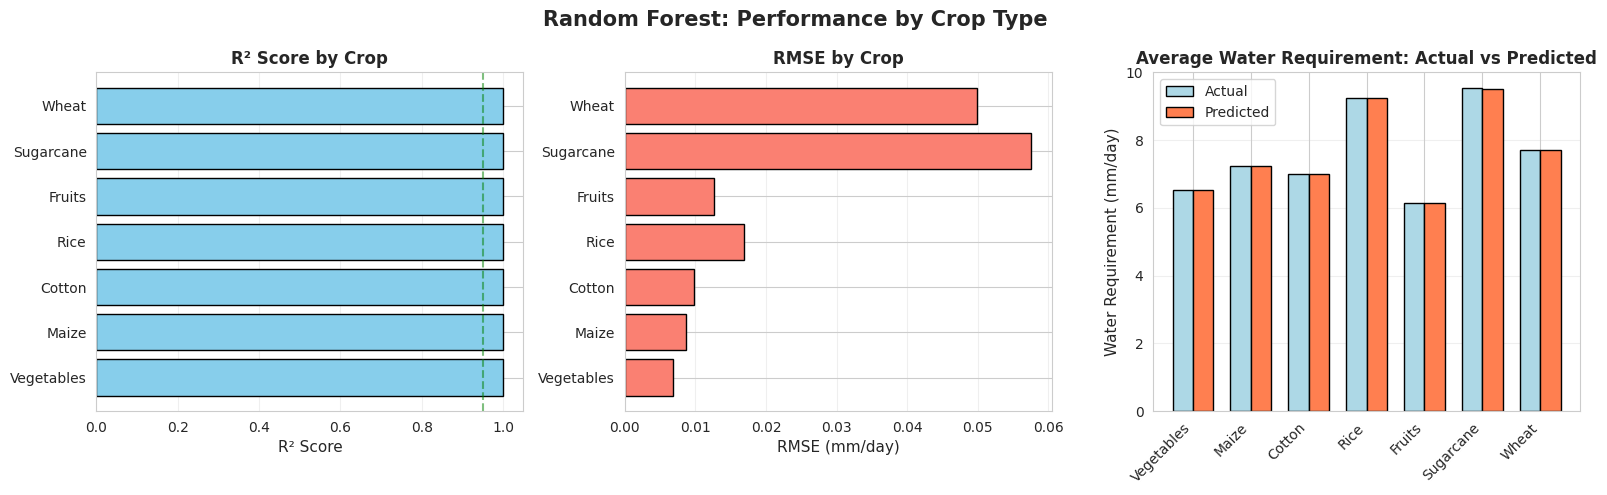

In [25]:

crop_performance = []

for crop in df_full['crop'].unique():
    crop_test_idx = df_full.loc[y_test.index, 'crop'] == crop

    if crop_test_idx.sum() > 0:
        y_test_crop = y_test[crop_test_idx]
        y_pred_crop = y_test_pred_best[crop_test_idx]

        crop_r2 = r2_score(y_test_crop, y_pred_crop)
        crop_rmse = np.sqrt(mean_squared_error(y_test_crop, y_pred_crop))
        crop_mae = mean_absolute_error(y_test_crop, y_pred_crop)
        crop_mape = mean_absolute_percentage_error(y_test_crop, y_pred_crop) * 100

        crop_performance.append({
            'Crop': crop,
            'Test_Samples': len(y_test_crop),
            'R²': crop_r2,
            'RMSE': crop_rmse,
            'Avg_Actual': y_test_crop.mean(),
            'Avg_Predicted': y_pred_crop.mean()
        })

crop_perf_df = pd.DataFrame(crop_performance).sort_values('R²', ascending=False)

print("\nModel Performance by Crop Type:")
print(crop_perf_df.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1,3, figsize=(16, 5))
fig.suptitle(f'{best_model_name}: Performance by Crop Type', fontsize=15, fontweight='bold')

# R² by crop
axes[0].barh(crop_perf_df['Crop'], crop_perf_df['R²'], color='skyblue', edgecolor='black')
axes[0].set_xlabel('R² Score', fontsize=11)
axes[0].set_title('R² Score by Crop', fontsize=12, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].axvline(x=0.95, color='green', linestyle='--', alpha=0.5)

# RMSE by crop
axes[1].barh(crop_perf_df['Crop'], crop_perf_df['RMSE'], color='salmon', edgecolor='black')
axes[1].set_xlabel('RMSE (mm/day)', fontsize=11)
axes[1].set_title('RMSE by Crop', fontsize=12, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# Actual vs Predicted average
x_pos = np.arange(len(crop_perf_df))
width = 0.35
axes[2].bar(x_pos - width/2, crop_perf_df['Avg_Actual'], width,
               label='Actual', color='lightblue', edgecolor='black')
axes[2].bar(x_pos + width/2, crop_perf_df['Avg_Predicted'], width,
               label='Predicted', color='coral', edgecolor='black')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(crop_perf_df['Crop'], rotation=45, ha='right')
axes[2].set_ylabel('Water Requirement (mm/day)', fontsize=11)
axes[2].set_title('Average Water Requirement: Actual vs Predicted', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Monthly Predictions


Monthly Water Requirement Predictions


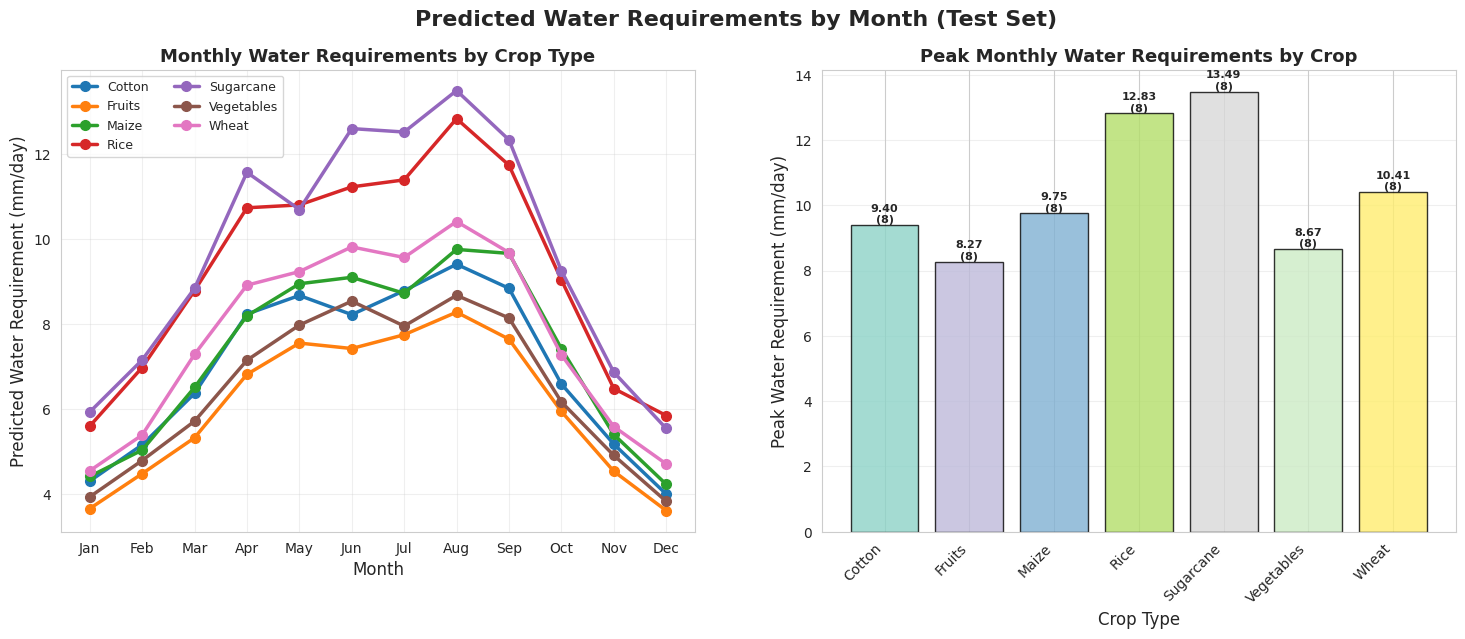

In [26]:

print("\nMonthly Water Requirement Predictions")

test_months = df_full.loc[y_test.index, 'month']
test_crops = df_full.loc[y_test.index, 'crop']

monthly_predictions_df = pd.DataFrame({
    'month': test_months,
    'crop': test_crops,
    'predicted_water_req': y_test_pred_best
})

monthly_avg = monthly_predictions_df.groupby(['month', 'crop'])['predicted_water_req'].mean().unstack()

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Predicted Water Requirements by Month (Test Set)', fontsize=16, fontweight='bold')

# 1. Line plot - All crops across months
ax1 = axes[0]
for crop in monthly_avg.columns:
    ax1.plot(monthly_avg.index, monthly_avg[crop], marker='o', linewidth=2.5,
             label=crop, markersize=7)
ax1.set_xlabel('Month', fontsize=12)
ax1.set_ylabel('Predicted Water Requirement (mm/day)', fontsize=12)
ax1.set_title('Monthly Water Requirements by Crop Type', fontsize=13, fontweight='bold')
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax1.legend(loc='best', fontsize=9, ncol=2)
ax1.grid(alpha=0.3)


# 2. Bar plot - Peak months by crop
ax3 = axes[1]
peak_months = monthly_avg.idxmax()
peak_values = monthly_avg.max()
x_pos = np.arange(len(peak_months))
colors_bar = plt.cm.Set3(np.linspace(0, 1, len(peak_months)))
bars = ax3.bar(x_pos, peak_values, color=colors_bar, edgecolor='black', alpha=0.8)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(peak_months.index, rotation=45, ha='right')
ax3.set_ylabel('Peak Water Requirement (mm/day)', fontsize=12)
ax3.set_xlabel('Crop Type', fontsize=12)
ax3.set_title('Peak Monthly Water Requirements by Crop', fontsize=13, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Add value labels and peak month
for i, (bar, peak_month, peak_val) in enumerate(zip(bars, peak_months, peak_values)):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{peak_val:.2f}\n({peak_month})',
            ha='center', va='bottom', fontsize=8, fontweight='bold')





## Example Predictions

In [27]:

print("\nExample: Recent Weather Conditions for Different Crops")
print("Last 10 data samples from the test set with actual vs predicted water requirements\n")
sample_idx = y_test.index[-10:]
sample_data = X_test.loc[sample_idx]
sample_scaled = X_test_scaled.loc[sample_idx]
sample_predictions = best_model.predict(sample_scaled)
sample_actual = y_test.loc[sample_idx]
sample_crops = df_full.loc[sample_idx, 'crop']

recommendation_df = pd.DataFrame({
    'Crop': sample_crops.values,
    'Solar_Rad': sample_data['ALLSKY_SFC_SW_DWN'].values,
    'Temp_Mean': sample_data['T2M_MEAN'].values,
    'Humidity': sample_data['RH2M'].values,
    'Wind_Speed': sample_data['WS2M'].values,
    'Actual_Req': sample_actual.values,
    'Predicted_Req': sample_predictions,
    'Error': np.abs(sample_actual.values - sample_predictions)
})

recommendation_df = recommendation_df.round({
    'Solar_Rad': 2,
    'Temp_Mean': 1,
    'Humidity': 1,
    'Wind_Speed': 2,
    'Actual_Req': 2,
    'Predicted_Req': 2,
    'Error': 3
})

print(recommendation_df.to_string(index=False))



Example: Recent Weather Conditions for Different Crops
Last 10 data samples from the test set with actual vs predicted water requirements

     Crop  Solar_Rad  Temp_Mean  Humidity  Wind_Speed  Actual_Req  Predicted_Req  Error
   Cotton      19.62       17.5      85.5        6.08        8.38           8.38  0.001
     Rice      12.99       18.4      86.8        8.05        7.39           7.39  0.003
    Maize      22.88       15.1      87.6        5.82        9.29           9.29  0.001
Sugarcane      10.99       16.0      70.2        2.72        8.71           8.71  0.000
    Wheat      11.55       13.1      89.0        9.07        4.21           4.21  0.000
     Rice       9.71       14.9      75.2        9.09        6.15           6.15  0.003
     Rice      13.19       18.3      86.2        4.89        8.54           8.54  0.003
     Rice      16.11       14.8      96.9        5.52        7.87           7.87  0.002
    Maize      14.18       15.7      89.2        6.72        5.81   

## Key Findings and Conclusions

### Project Summary

In [28]:


print("\nDATASET OVERVIEW")
print(f"- Data Source: NASA POWER Satellite System")
print(f"- Time Period: 2015-2025 (10 years)")
print(f"- Total Records: {len(df_full):,}")
print(f"- Daily Observations: {len(df_clean):,}")
print(f"- Crops Analyzed: {len(crop_database)}")
print(f"- Features Engineered: {len(selected_features)}")

print("\nMODEL PERFORMANCE")
print(f"- Best Model: {best_model_name}")
print(f"- Test R² Score: {results_df.iloc[0]['Test_R2']:.4f} ({results_df.iloc[0]['Test_R2']*100:.2f}%)")
print(f"- Test RMSE: {results_df.iloc[0]['Test_RMSE']:.4f} mm/day")

print("\nCROP WATER REQUIREMENTS (Average)")
for crop in sorted(crop_database.keys(), key=lambda x: crop_database[x]['kc'], reverse=True):
    avg_req = df_full[df_full['crop']==crop]['crop_water_req'].mean()
    kc = crop_database[crop]['kc']
    print(f"- {crop:12s}: {avg_req:.2f} mm/day  (Kc={kc:.2f})  →  {avg_req*30:.0f} mm/month")

print("\nKey Findings:")
print("- Solar radiation is the primary driver of water requirements")
print("- Temperature and humidity significantly impact ET0")
print("- Model works consistently across all crop types")

print("\nPractical Applications:")
print("- Precision irrigation scheduling for farmers")
print("- Water resource management")
print("- Drought monitoring and early warning")
print("- Uses free satellite data (no weather stations needed)")


DATASET OVERVIEW
- Data Source: NASA POWER Satellite System
- Time Period: 2015-2025 (10 years)
- Total Records: 25,536
- Daily Observations: 3,648
- Crops Analyzed: 7
- Features Engineered: 10

MODEL PERFORMANCE
- Best Model: Random Forest
- Test R² Score: 0.9999 (99.99%)
- Test RMSE: 0.0302 mm/day

CROP WATER REQUIREMENTS (Average)
- Sugarcane   : 9.66 mm/day  (Kc=1.25)  →  290 mm/month
- Rice        : 9.27 mm/day  (Kc=1.20)  →  278 mm/month
- Wheat       : 7.73 mm/day  (Kc=1.00)  →  232 mm/month
- Maize       : 7.34 mm/day  (Kc=0.95)  →  220 mm/month
- Cotton      : 6.95 mm/day  (Kc=0.90)  →  209 mm/month
- Vegetables  : 6.57 mm/day  (Kc=0.85)  →  197 mm/month
- Fruits      : 6.18 mm/day  (Kc=0.80)  →  185 mm/month

Key Findings:
- Solar radiation is the primary driver of water requirements
- Temperature and humidity significantly impact ET0
- Model works consistently across all crop types

Practical Applications:
- Precision irrigation scheduling for farmers
- Water resource manag